In [1]:
import ast
import collections
import pickle
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
#@title Load the dataset. (Chạy ô này)

# Đường dẫn
path = 'data/movies_dataset/'
path_save = 'model/'
# path_save = '/content/drive/MyDrive/Project II/'
# path = '/content/drive/MyDrive/Project II/data/movies_dataset/'

ratings = pd.read_csv(path + 'ratings_small.csv').drop(columns='timestamp')
movies = pd.read_csv(path + 'movies_metadata.csv')[['id', 'genres', 'original_title', 'title']]
id_map = pd.read_csv(path + 'links_small.csv')[['movieId', 'tmdbId']].rename(columns={'tmdbId': 'id'})

C:\Users\Duy\AppData\Local\Temp\ipykernel_7132\191560175.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv(path + 'movies_metadata.csv')[['id', 'genres', 'original_title', 'title']]


In [3]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan


# Vì một số phâm có thể thuộc nhiều thể loại, nên ta có thể tạo các cột 'genre' khác nhau như:
# - all_genres: tất cả các thể loại của bộ phim.
# - genre: lấy ngẫu nhiên từ các thể loại của bộ phim.
def mark_genres_for_tmdb(movies):
    def get_random_genre(gs):
        genres_list = ast.literal_eval(gs)
        active = [genre['name'] for genre in genres_list]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)

    def get_all_genres(gs):
        genres_list = ast.literal_eval(gs)
        active = [genre['name'] for genre in genres_list]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)

    movies['genre'] = movies['genres'].apply(get_random_genre)
    movies['all_genres'] = movies['genres'].apply(get_all_genres)

In [4]:
movies['id'] = movies['id'].apply(convert_int)
id_map['id'] = id_map['id'].apply(convert_int)
indices_map = id_map.set_index('id')

mark_genres_for_tmdb(movies)
id_map = id_map.merge(movies[['title', 'id', 'genre', 'all_genres']], on='id').drop_duplicates()

In [5]:
def random_split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

def stratified_split(data, filter_by="user", min_rating=1, ratio=0.7, col_user='userId', col_item='movieId'):
    if min_rating > 1:
        if filter_by == "user":
            # Lọc người dùng có ít nhất min_rating đánh giá
            filtered_data = data.groupby(col_user).filter(lambda x: len(x) >= min_rating)
            stratify_col = col_user
        elif filter_by == "item":
            # Lọc mặt hàng có ít nhất min_rating đánh giá
            filtered_data = data.groupby(col_item).filter(lambda x: len(x) >= min_rating)
            stratify_col = col_item
        else:
            raise ValueError("filter_by must be either 'user' or 'item'")
    else:
        # Nếu min_rating <= 1, không lọc dữ liệu
        filtered_data = data
        stratify_col = col_user if filter_by == "user" else col_item

    # Chia dữ liệu thành hai phần: phần có các nhóm nhỏ hơn 2 mẫu và phần còn lại
    value_counts = filtered_data[stratify_col].value_counts()
    small_groups = value_counts[value_counts < 2].index
    large_groups = value_counts[value_counts >= 2].index
    
    small_group_data = filtered_data[filtered_data[stratify_col].isin(small_groups)]
    large_group_data = filtered_data[filtered_data[stratify_col].isin(large_groups)]
    
    if large_group_data.empty:
        raise ValueError("No groups with at least 2 samples after filtering.")
    
    # Chia dữ liệu phần lớn theo tỷ lệ ratio với stratify theo cột được chọn
    train_large, test_large = train_test_split(large_group_data, test_size=1-ratio, stratify=large_group_data[stratify_col])
    
    # Đưa các nhóm nhỏ hơn 2 mẫu vào tập huấn luyện
    train = pd.concat([train_large, small_group_data]).reset_index(drop=True)
    test = test_large.reset_index(drop=True)
    
    return train, test

In [6]:
def build_rating_sparse_tensor(rating_df):
    indices = rating_df[['userId', 'movieId']].values
    values = rating_df['rating'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[rating_df['userId'].nunique(), rating_df['movieId'].nunique()]
    )

In [7]:
# Function to compute mean rating for each movie
def compute_movie_means(data_df):
    movie_means = data_df.groupby('movieId')['rating'].mean().fillna(0)
    movie_means_array = np.zeros(data_df['movieId'].max() + 1)
    movie_means_array[movie_means.index] = movie_means.values
    return movie_means_array

In [8]:
def mse(sparse_ratings, movie_means, user_embeddings, movie_embeddings, user_biases, movie_biases):
    user_emb = tf.nn.embedding_lookup(user_embeddings, sparse_ratings.indices[:, 0])
    movie_emb = tf.nn.embedding_lookup(movie_embeddings, sparse_ratings.indices[:, 1])
    user_bias = tf.nn.embedding_lookup(user_biases, sparse_ratings.indices[:, 0])[:, 0]
    movie_bias = tf.nn.embedding_lookup(movie_biases, sparse_ratings.indices[:, 1])[:, 0]
    movie_mean = tf.nn.embedding_lookup(movie_means, sparse_ratings.indices[:, 1])

    # y_predict = tf.reduce_sum(user_emb * movie_emb, axis=1) + user_bias + movie_mean
    y_predict = tf.reduce_sum(user_emb * movie_emb, axis=1) + user_bias + movie_bias + movie_mean
    loss = tf.keras.losses.mean_squared_error(sparse_ratings.values, y_predict)
    return loss

def norm_2(X):
    return tf.reduce_sum(X*X)/X.shape[0]

def reg(user_embeddings, movie_embeddings, user_biases, movie_biases, regularization_coeff=.1):
    # return regularization_coeff * (norm_2(user_embeddings) + norm_2(movie_embeddings))
    return regularization_coeff * (norm_2(user_embeddings) + norm_2(movie_embeddings) + 
                norm_2(tf.expand_dims(user_biases, axis=1)) + norm_2(tf.expand_dims(movie_biases, axis=1)))

def mse_reg(sparse_ratings, movie_means, user_embeddings, movie_embeddings, user_biases, movie_biases, regularization_coeff=.1):
    mse_loss = mse(sparse_ratings, movie_means, user_embeddings, movie_embeddings, user_biases, movie_biases)
    reg_loss = reg(user_embeddings, movie_embeddings, user_biases, movie_biases, regularization_coeff=regularization_coeff)
    
    total_loss = mse_loss + reg_loss
    return total_loss

In [9]:
class Model(object):
    def __init__(self, embedding_vars, bias_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._bias_vars = bias_vars
        self._loss = loss
        self.metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._biases = {k: None for k in bias_vars}
        self._session = None
        self.history = collections.defaultdict(list)
        self._data_train = None

    def set_data_train(self, data_train):
        self._data_train = data_train

    @property
    def embeddings(self):
        return self._embeddings

    @property
    def biases(self):
        return self._biases

    def fit(self, epochs=1000, learning_rate=0.1, patience=50, plot_result=True, optimizer=tf.optimizers.SGD):
        opt = optimizer(learning_rate)

        @tf.function
        def train_step():
            with tf.GradientTape() as tape:
                loss_value = self._loss()
            grads = tape.gradient(loss_value, list(self._embedding_vars.values()) + list(self._bias_vars.values()))
            opt.apply_gradients(zip(grads, list(self._embedding_vars.values()) + list(self._bias_vars.values())))
            return

        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(epochs + 1):
            train_step()
            
            results = {k: v() for metric in self.metrics for k, v in metric.items()}
            for k, v in results.items():
                self.history[k].append(v.numpy())

            # Early stopping logic
            current_loss = results['test_error'].numpy()
            if current_loss < best_loss:
                best_loss = current_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Stopping early at epoch {epoch}")
                    break

            if epoch % 20 == 0 or epoch == epochs:
                loaded = (epoch * 60) // epochs - 1
                loading_display = f'[{"=" * loaded}>{"-" * (59 - loaded)}]'
                error_display = f"\rEpoch {epoch}: train_error: {results['train_error'].numpy()}, test_error: {results['test_error'].numpy()}"
                clear_output(wait=False)
                print(loading_display)
                print(error_display)
        print(f"best_loss: {best_loss}")

        for k, v in self._embedding_vars.items():
            self._embeddings[k] = v.numpy()
        for k, v in self._bias_vars.items():
            self._biases[k] = v.numpy()

        if plot_result:
            plt.figure(figsize=(10, 5))
            epochs_range = list(range(len(self.history['train_error'])))
            plt.plot(epochs_range, self.history['train_error'], label='Training Error')
            plt.plot(epochs_range, self.history['test_error'], label='Test Error')
            plt.plot(epochs_range, self.history['regularization_loss'], label='Regularization Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Error')
            plt.title('Training and Test Error over Epochs')
            plt.legend()
            plt.show()

    def save(self, path):
        model_data = {
            'embedding_vars': {k: v.numpy() for k, v in self._embedding_vars.items()},
            'bias_vars': {k: v.numpy() for k, v in self._bias_vars.items()},
            'history': self.history
        }
        with open(path, 'wb') as f:
            pickle.dump(model_data, f)
            
    def load(self, path):
        with open(path, 'rb') as f:
            model_data = pickle.load(f)
        
        for k, v in model_data['embedding_vars'].items():
            self._embedding_vars[k].assign(v)
        for k, v in model_data['bias_vars'].items():
            self._bias_vars[k].assign(v)
        
        self.history = model_data['history']
        self._embeddings = {k: v for k, v in model_data['embedding_vars'].items()}
        self._biases = {k: v for k, v in model_data['bias_vars'].items()}

    def get_watched_movies(self, userId):
        if self._data_train is not None:
            watched_movies = self._data_train[self._data_train['userId'] == userId]['movieId'].tolist()
            return watched_movies
        else:
            raise ValueError("Training data not set. Please set the training data using 'set_data_train' method.")

    def predict(self, userId, movieId):
        user_embedding = self._embeddings['user_id'][userId]
        movie_embedding = self._embeddings['movie_id'][movieId]
        user_bias = self._biases['user_bias'][userId]
        movie_bias = self._biases['movie_bias'][movieId]
        prediction = tf.reduce_sum(user_embedding * movie_embedding) + user_bias + movie_bias
        return prediction.numpy()

    def recommend(self, userId, top_k=10):
        if self._data_train is not None:
            watched_movies = set(self.get_watched_movies(userId))
            user_embedding = tf.expand_dims(self._embeddings['user_id'][userId], axis=0)  # Thêm trục mới để tương thích với phép nhân ma trận
            user_bias = self._biases['user_bias'][userId]
            movie_embeddings = self._embeddings['movie_id']
            movie_biases = self._biases['movie_bias']
            
            predictions = tf.matmul(user_embedding, movie_embeddings, transpose_b=True) + user_bias + tf.squeeze(movie_biases, axis=1)
            predictions_np = predictions.numpy().flatten()
    
            # Filter out movies that the user has already watched
            unwatched_movie_indices = [i for i in range(len(predictions_np)) if i not in watched_movies]
            unwatched_predictions = predictions_np[unwatched_movie_indices]
            
            # Get top k recommendations
            top_k_indices = np.argsort(unwatched_predictions)[-top_k:][::-1]
            top_k_movie_indices = [unwatched_movie_indices[i] for i in top_k_indices]
    
            return top_k_movie_indices
        else:
            raise ValueError("Training data not set. Please set the training data using 'set_data_train' method.")


In [10]:
def build_model(data_train, data_test, movie_means_series, X_init=None, X_bias_init=None, X_trainable=True, embedding_dim=3, regularization_coeff=.1, init_stddev=1.):
    n_user = max(data_train['userId'].max(), data_test['userId'].max()) + 1
    n_movie = max(data_train['movieId'].max(), data_test['movieId'].max()) + 1
    
    # Khởi tạo W và W_bias
    W = tf.Variable(tf.random.normal([n_user, embedding_dim], stddev=init_stddev))
    W_bias = tf.Variable(tf.zeros([n_user, 1]))
    
    # Kiểm tra và khởi tạo X và X_bias từ X_init và X_bias_init nếu có
    if X_init is None:
        X = tf.Variable(tf.random.normal([n_movie, embedding_dim], stddev=init_stddev), trainable=X_trainable)
    else:
        X = tf.Variable(X_init, trainable=X_trainable)
    
    if X_bias_init is None:
        X_bias = tf.Variable(tf.zeros([n_movie, 1]), trainable=X_trainable)
    else:
        X_bias = tf.Variable(X_bias_init, trainable=X_trainable)
    
    # Tạo constant movie_means
    movie_means = tf.constant(movie_means_series, dtype=tf.float32)
    
    # Định nghĩa các hàm loss
    train_loss = lambda: mse(build_rating_sparse_tensor(data_train), movie_means, W, X, W_bias, X_bias)
    test_loss = lambda: mse(build_rating_sparse_tensor(data_test), movie_means, W, X, W_bias, X_bias)
    total_loss = lambda: mse_reg(build_rating_sparse_tensor(data_train), movie_means, W, X, W_bias, X_bias, regularization_coeff=regularization_coeff)
    regularization_loss = lambda: reg(W, X, W_bias, X_bias, regularization_coeff=regularization_coeff)
    
    # Định nghĩa các losses và loss_components
    losses = {
        'train_error': train_loss,
        'test_error': test_loss,
        'regularization_loss': regularization_loss,
    }
    loss_components = {}
    
    # Tạo embeddings và biases
    embeddings = {
        "user_id": W,
        "movie_id": X
    }
    biases = {
        "user_bias": W_bias,
        "movie_bias": X_bias
    }
    
    # Tạo model mới và set data_train
    model = Model(embeddings, biases, total_loss, [losses, loss_components])
    model.set_data_train(data_train)  # Set the training data
    
    return model

In [11]:
def movie_embedding_norm(model):
    # Lấy các movieId có trong df
    movie_ids_in_ratings = ratings['movieId'].unique()

    # Tạo một mask để lọc các embedding tương ứng với movie_ids_in_ratings
    mask = np.isin(np.arange(0, model.embeddings['movie_id'].shape[0]), movie_ids_in_ratings)
    filtered_embeddings = model.embeddings['movie_id'][mask]

    # Tính norm của các embeddings
    norms = np.linalg.norm(filtered_embeddings, axis=1)

    # Tính số lượng ratings cho mỗi bộ phim
    num_ratings = ratings.groupby('movieId').size().reindex(movie_ids_in_ratings, fill_value=0)

    # Tạo DataFrame chứa thông tin cần thiết
    movie_embedding_df = pd.DataFrame({
        "movieId": movie_ids_in_ratings,
        "norm": norms,
        "num_ratings": num_ratings.values
    })

    movie_embedding_df = id_map.merge(movie_embedding_df, on='movieId')

    # Vẽ biểu đồ với cột num_ratings trên trục x và cột norm trên trục y
    chart = alt.Chart(movie_embedding_df).mark_circle(size=10).encode(
        x=alt.X('num_ratings:Q', axis=alt.Axis(title='Number of Ratings')),
        y=alt.Y('norm:Q', axis=alt.Axis(title='Embedding Norm')),
        color='genre:N',
        tooltip=['title:N', 'genre:N', 'num_ratings:Q', 'norm:Q']
    ).properties(
        width=600,
        height=400,
        title='Movie Embeddings: Number of Ratings vs Norm'
    )

    return chart


def movie_bias_vs_num_ratings(model):
    # Lấy các movieId có trong df
    movie_ids_in_ratings = ratings['movieId'].unique()

    # Tạo một mask để lọc các bias tương ứng với movie_ids_in_ratings
    mask = np.isin(np.arange(0, model.biases['movie_bias'].shape[0]), movie_ids_in_ratings)
    filtered_biases = model.biases['movie_bias'][mask]

    # Chuyển đổi bias thành một chiều
    biases = filtered_biases.flatten()

    # Tính số lượng ratings cho mỗi bộ phim
    num_ratings = ratings.groupby('movieId').size().reindex(movie_ids_in_ratings, fill_value=0)

    # Tạo DataFrame chứa thông tin cần thiết
    movie_bias_df = pd.DataFrame({
        "movieId": movie_ids_in_ratings,
        "bias": biases,
        "num_ratings": num_ratings.values
    })

    movie_bias_df = id_map.merge(movie_bias_df, on='movieId')

    # Vẽ biểu đồ với cột num_ratings trên trục x và cột bias trên trục y
    chart = alt.Chart(movie_bias_df).mark_circle(size=10).encode(
        x=alt.X('num_ratings:Q', axis=alt.Axis(title='Number of Ratings')),
        y=alt.Y('bias:Q', axis=alt.Axis(title='Bias')),
        color='genre:N',
        tooltip=['title:N', 'genre:N', 'num_ratings:Q', 'bias:Q']
    ).properties(
        width=600,
        height=400,
        title='Movie Bias: Number of Ratings vs Bias'
    )

    return chart


# Hàm _visualize_movie_embeddings sử dụng Altair để hiển thị trực quan
def _tsne_movie_embeddings(data, x, y):
    nearest = alt.selection_point(encodings=['x', 'y'], on='mouseover', nearest=True, empty=True)
    base = alt.Chart(data).mark_circle().encode(
        x=alt.X(x, axis=alt.Axis(title='t-SNE Component 1')),
        y=alt.Y(y, axis=alt.Axis(title='t-SNE Component 2')),
        color='genre:N',
        tooltip=['title:N', 'genre:N', 'all_genres:N']
    ).properties(
        width=600,
        height=600
    ).add_params(nearest)

    text = alt.Chart(data).mark_text(align='left', dx=5, dy=-5).encode(
        x=x,
        y=y,
        text=alt.condition(nearest, 'title', alt.value(''))
    )

    return alt.layer(base, text)


def tsne_movie_embeddings(model):
    # Lấy các movieId có trong df
    movie_ids_in_ratings = ratings['movieId'].unique()

    # Tạo một mask để lọc các embedding tương ứng với movie_ids_in_ratings
    mask = np.isin(np.arange(0, model.embeddings['movie_id'].shape[0]), movie_ids_in_ratings)
    filtered_embeddings = model.embeddings['movie_id'][mask]

    # Kiểm tra số lượng mẫu để xác định perplexity
    n_samples = filtered_embeddings.shape[0]
    perplexity = min(40, n_samples - 1)  # Đảm bảo perplexity nhỏ hơn số lượng mẫu

    # Sử dụng t-SNE để giảm chiều dữ liệu
    tsne = TSNE(n_components=2, perplexity=perplexity, metric='cosine', early_exaggeration=10.0, init='pca',
                verbose=True, n_iter=400)
    tsne_results = tsne.fit_transform(filtered_embeddings)

    movie_embedding_df = pd.DataFrame({"movieId": movie_ids_in_ratings}).set_index('movieId')

    # Thêm kết quả t-SNE vào DataFrame movies
    movie_embedding_df['x'] = tsne_results[:, 0]
    movie_embedding_df['y'] = tsne_results[:, 1]

    movie_embedding_df = id_map.merge(movie_embedding_df, on='movieId')

    return _tsne_movie_embeddings(movie_embedding_df, 'x', 'y')

In [12]:
def compute_scores(target_embedding, embeddings, measure):
    if measure == 'DOT':
        return np.dot(embeddings, target_embedding)
    elif measure == 'COSINE':
        return cosine_similarity(embeddings, target_embedding.reshape(1, -1)).flatten()
    else:
        raise ValueError("Similarity measure must be 'DOT' or 'COSINE'")

def movie_neighbors(model, title_substring, measure='DOT', k=11):
    # Search for movie ids that match the given substring.
    movie_df = id_map.dropna(subset=['title']).drop(columns=['id'])
    # movie_df = movies[['movieId', 'title', 'all_genres']].dropna(subset=['title'])
    result = movie_df[movie_df['title'].str.contains(title_substring, case=False, regex=False)]
    titles = result['title'].values
    if len(result) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(result) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
            ", ".join(titles[1:])))
    movie_id = result['movieId'].values[0]
    movie_embeddings = model.embeddings["movie_id"]
    
    scores = compute_scores(movie_embeddings[movie_id], movie_embeddings, measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: scores,
        'movieId': range(len(scores))
    }).merge(movie_df, on='movieId', how='inner')
    
    display(df.sort_values([score_key], ascending=False).head(k))

In [13]:
def get_movie_info(df, list_id):
    # Lọc các hàng trong df có movieId nằm trong list_id
    filtered_df = df[df['movieId'].isin(list_id)]
    
    # Hiển thị kết quả
    return filtered_df

def search_movie_id(name):
    movie_df = id_map.dropna(subset=['title']).drop(columns=['id'])
    # movie_df = movies[['movieId', 'title', 'all_genres']].dropna(subset=['title'])
    return movie_df[movie_df['title'].str.contains(name, case=False, regex=False)]

In [14]:
movie_means_series = compute_movie_means(ratings)
data_train = pd.read_csv(path + 'ratings_train.csv')
data_test = pd.read_csv(path + 'ratings_test.csv')

[========>---------------------------------------------------]
Epoch 80: train_error: 0.6680633425712585, test_error: 0.7057029008865356
Stopping early at epoch 89
best_loss: 0.7026348114013672


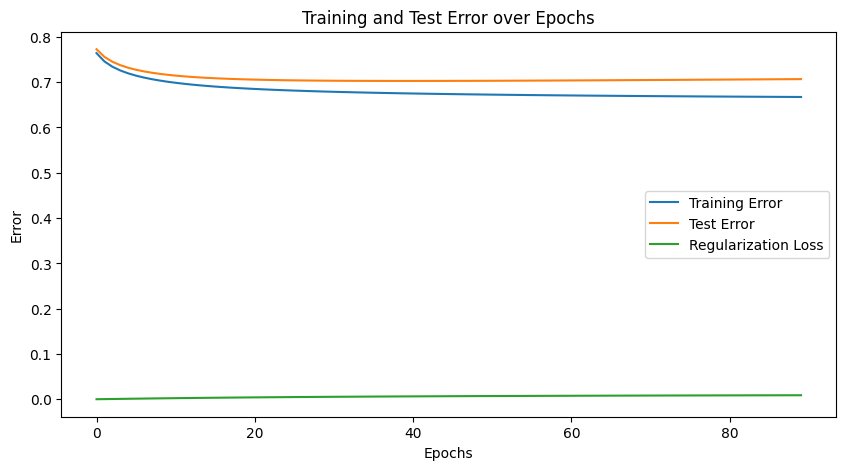

In [15]:
model = build_model(data_train, data_test, movie_means_series, embedding_dim=35, regularization_coeff=0.1, init_stddev=.005)
model.fit(epochs=500, learning_rate=20, patience=50)
model.save(path_save + 'early___model.pkl')

In [15]:
model = build_model(data_train, data_test, movie_means_series, embedding_dim=35, regularization_coeff=0.1, init_stddev=.005)
model.load(path_save + 'saved_model.pkl')

In [188]:
ratings_new_user = pd.read_csv(path + 'ratings_new_user.csv')
empty_df = pd.DataFrame(columns=['userId', 'movieId', 'rating'])

# Truyền X_init và X_bias_init từ model cũ (assumed)
X_init = model.embeddings['movie_id']
X_bias_init = model.biases['movie_bias']

new_model = build_model(ratings_new_user, ratings_new_user, movie_means_series, X_init=X_init, X_bias_init=X_bias_init, X_trainable=False, embedding_dim=35, regularization_coeff=1., init_stddev=0)

[===========================================================>]
Epoch 10: train_error: 0.18861033022403717, test_error: 0.18861033022403717
best_loss: 0.18861033022403717


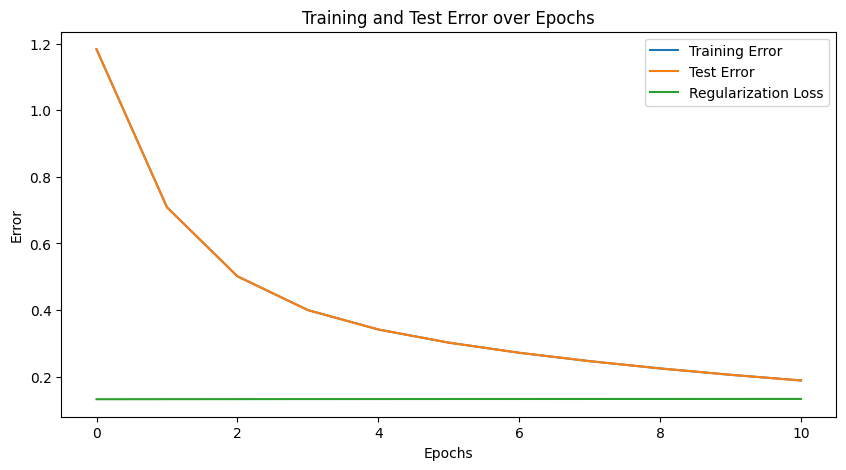

In [189]:
new_model.fit(epochs=10, learning_rate=.05, patience=10)

In [191]:
get_movie_info(id_map, new_model.get_watched_movies(672))

,movieId,id,title,genre,all_genres
4120,5349,557.0,Spider-Man,Fantasy,Fantasy-Action
4624,6333,36658.0,X2,Action,Adventure-Action-Science Fiction-Thriller
5521,8636,558.0,Spider-Man 2,Action,Action-Adventure-Fantasy
6722,52722,559.0,Spider-Man 3,Fantasy,Fantasy-Action-Adventure
7868,88140,1771.0,Captain America: The First Avenger,Science Fiction,Action-Adventure-Science Fiction
8111,95510,1930.0,The Amazing Spider-Man,Adventure,Action-Adventure-Fantasy
8577,110553,102382.0,The Amazing Spider-Man 2,Fantasy,Action-Adventure-Fantasy
8805,122892,99861.0,Avengers: Age of Ultron,Action,Action-Adventure-Science Fiction


In [190]:
get_movie_info(id_map, new_model.recommend(672))

,movieId,id,title,genre,all_genres
2760,3415,1396.0,Mirror,History,Drama-History
3455,4306,808.0,Shrek,Animation,Adventure-Animation-Comedy-Family-Fantasy
3547,4447,8835.0,Legally Blonde,Comedy,Comedy
3847,4896,671.0,Harry Potter and the Philosopher's Stone,Fantasy,Adventure-Fantasy-Family
5428,8360,809.0,Shrek 2,Comedy,Adventure-Animation-Comedy-Family-Fantasy
6818,55250,13680.0,The Game Plan,Comedy,Comedy-Family
7836,86911,45243.0,The Hangover Part II,Comedy,Comedy
8344,102686,109439.0,The Hangover Part III,Comedy,Comedy
8530,108729,181886.0,Enemy,Thriller,Thriller-Mystery
8739,116823,131631.0,The Hunger Games: Mockingjay - Part 1,Science Fiction,Science Fiction-Adventure-Thriller


In [182]:
search_movie_id("Avenger")

,movieId,title,genre,all_genres
1749,2153,The Avengers,Thriller,Thriller
2984,3693,The Toxic Avenger,Comedy,Science Fiction-Action-Comedy-Horror
2985,3694,The Toxic Avenger Part II,Comedy,Comedy-Horror-Action
2986,3695,The Toxic Avenger Part III: The Last Temptatio...,Action,Comedy-Horror-Action-Science Fiction
7868,88140,Captain America: The First Avenger,Science Fiction,Action-Adventure-Science Fiction
7914,89745,The Avengers,Science Fiction,Science Fiction-Action-Adventure
8805,122892,Avengers: Age of Ultron,Action,Action-Adventure-Science Fiction


In [29]:
get_movie_info(id_map, model.get_watched_movies(632))[['title', 'all_genres']]

,title,all_genres
61,Bio-Dome,Comedy
82,Black Sheep,Comedy
100,Braveheart,Action-Drama-History-War
129,Apollo 13,Drama
266,Pulp Fiction,Thriller-Crime
284,The Shawshank Redemption,Drama-Crime
309,Ace Ventura: Pet Detective,Comedy-Mystery
427,Jurassic Park,Adventure-Science Fiction
522,Terminator 2: Judgment Day,Action-Thriller-Science Fiction
525,The Silence of the Lambs,Crime-Drama-Thriller


In [30]:
get_movie_info(id_map, model.recommend(632))[['title', 'all_genres']]

,title,all_genres
379,Cabin Boy,Comedy
1210,Gridlock'd,Crime-Drama-Comedy
1454,Homegrown,Drama-Action-Comedy-Thriller-Crime
1641,D2: The Mighty Ducks,Action-Comedy-Drama-Family
3146,Anatomy,Horror-Thriller
4687,"Heaven Knows, Mr. Allison",Adventure-Drama-War
5925,In July,Adventure-Comedy-Romance
6097,Be Cool,Comedy-Crime
7435,The Princess and the Frog,Romance-Family-Animation-Music
8307,Oz: The Great and Powerful,Fantasy-Adventure-Family


In [16]:
# Hiển thị biểu đồ
chart = tsne_movie_embeddings(model)
chart.display()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9066 samples in 0.002s...
[t-SNE] Computed neighbors for 9066 samples in 4.894s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9066
[t-SNE] Computed conditional probabilities for sample 2000 / 9066
[t-SNE] Computed conditional probabilities for sample 3000 / 9066
[t-SNE] Computed conditional probabilities for sample 4000 / 9066
[t-SNE] Computed conditional probabilities for sample 5000 / 9066
[t-SNE] Computed conditional probabilities for sample 6000 / 9066
[t-SNE] Computed conditional probabilities for sample 7000 / 9066
[t-SNE] Computed conditional probabilities for sample 8000 / 9066
[t-SNE] Computed conditional probabilities for sample 9000 / 9066
[t-SNE] Computed conditional probabilities for sample 9066 / 9066
[t-SNE] Mean sigma: 0.206651
[t-SNE] KL divergence after 50 iterations with early exaggeration: 77.019135
[t-SNE] KL divergence after 400 iterations: 4.665819


alt.LayerChart(...)

In [33]:
movie_neighbors(model, "Aladdin", measure='DOT', k=11)
movie_neighbors(model, "Aladdin", measure='COSINE', k=11)
movie_neighbors(model, "Beauty and the Beast", measure='DOT', k=11)
movie_neighbors(model, "Beauty and the Beast", measure='COSINE', k=11)
movie_neighbors(model, "Spider-man", measure='DOT', k=11)
movie_neighbors(model, "Spider-man", measure='COSINE', k=11)
movie_neighbors(model, "Star wars", measure='DOT', k=11)
movie_neighbors(model, "Star wars", measure='COSINE', k=11)

Nearest neighbors of : Aladdin.
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves]


,DOT score,movieId,title,genre,all_genres
521,4.851545,588,Aladdin,Family,Animation-Family-Comedy-Adventure-Fantasy-Romance
527,3.473060,595,Beauty and the Beast,Music,Romance-Family-Animation-Fantasy-Music
321,2.279689,356,Forrest Gump,Romance,Comedy-Drama-Romance
2144,2.161015,2683,Austin Powers: The Spy Who Shagged Me,Crime,Adventure-Comedy-Crime-Science Fiction
519,2.041900,586,Home Alone,Comedy,Comedy-Family
2502,2.006150,3114,Toy Story 2,Family,Animation-Comedy-Family
0,1.821416,1,Toy Story,Family,Animation-Comedy-Family
1587,1.758676,2028,Saving Private Ryan,History,Drama-History-War
520,1.752261,587,Ghost,Mystery,Fantasy-Drama-Thriller-Mystery-Romance
328,1.742103,364,The Lion King,Animation,Family-Animation-Drama


Nearest neighbors of : Aladdin.
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves]


,COSINE score,movieId,title,genre,all_genres
521,1.000000,588,Aladdin,Family,Animation-Family-Comedy-Adventure-Fantasy-Romance
527,0.675691,595,Beauty and the Beast,Music,Romance-Family-Animation-Fantasy-Music
715,0.673366,897,For Whom the Bell Tolls,Romance,Drama-History-Romance-Thriller
5248,0.615851,7835,Song of the Thin Man,Crime,Comedy-Crime-Drama-Mystery-Thriller
7822,0.601654,88125,Harry Potter and the Deathly Hallows: Part 2,Adventure,Family-Fantasy-Adventure
7335,0.573155,71535,Zombieland,Horror,Comedy-Horror
5150,0.567141,7444,13 Going on 30,Romance,Comedy-Fantasy-Romance
949,0.566301,1194,Up in Smoke,Comedy,Comedy
6892,0.559509,58301,Funny Games,Horror,Horror-Thriller-Crime
125,0.547868,146,The Amazing Panda Adventure,Drama,Action-Adventure-Drama-Family


Nearest neighbors of : Beauty and the Beast.
[Found more than one matching movie. Other candidates: Beauty and the Beast]


,DOT score,movieId,title,genre,all_genres
527,5.445632,595,Beauty and the Beast,Music,Romance-Family-Animation-Fantasy-Music
521,3.473060,588,Aladdin,Family,Animation-Family-Comedy-Adventure-Fantasy-Romance
32,2.777945,34,Babe,Comedy,Fantasy-Drama-Comedy-Family
2502,2.457111,3114,Toy Story 2,Family,Animation-Comedy-Family
0,2.354197,1,Toy Story,Family,Animation-Comedy-Family
304,2.270248,339,While You Were Sleeping,Drama,Comedy-Drama-Romance
1117,2.063574,1380,Grease,Romance,Romance
913,2.048637,1148,The Wrong Trousers,Animation,Animation-Comedy-Family
2996,2.038629,3751,Chicken Run,Comedy,Animation-Comedy-Family
837,1.999608,1035,The Sound of Music,Drama,Drama-Family-Music-Romance


Nearest neighbors of : Beauty and the Beast.
[Found more than one matching movie. Other candidates: Beauty and the Beast]


,COSINE score,movieId,title,genre,all_genres
527,1.000000,595,Beauty and the Beast,Music,Romance-Family-Animation-Fantasy-Music
521,0.675691,588,Aladdin,Family,Animation-Family-Comedy-Adventure-Fantasy-Romance
304,0.636484,339,While You Were Sleeping,Drama,Comedy-Drama-Romance
4312,0.635078,5799,Exodus,War,Action-Drama-History-War
2061,0.632096,2573,Tango,Foreign,Drama-Foreign-Romance
210,0.624617,238,Far from Home: The Adventures of Yellow Dog,Action,Action-Adventure-Drama-Family
2502,0.623593,3114,Toy Story 2,Family,Animation-Comedy-Family
770,0.620988,953,It's a Wonderful Life,Family,Drama-Family-Fantasy
2555,0.615856,3182,Mr. Death: The Rise and Fall of Fred A. Leucht...,Documentary,Documentary
8078,0.615506,95780,Dragon Ball Z: Bio-Broly,Action,Action-Animation


Nearest neighbors of : Spider-Man.
[Found more than one matching movie. Other candidates: Spider-Man 2, Spider-Man 3, The Amazing Spider-Man, The Amazing Spider-Man 2]


,DOT score,movieId,title,genre,all_genres
4079,3.938050,5349,Spider-Man,Action,Fantasy-Action
5480,3.025252,8636,Spider-Man 2,Fantasy,Action-Adventure-Fantasy
3414,2.756948,4306,Shrek,Adventure,Adventure-Animation-Comedy-Family-Fantasy
5022,2.439388,7153,The Lord of the Rings: The Return of the King,Action,Adventure-Fantasy-Action
4583,2.388952,6333,X2,Thriller,Adventure-Action-Science Fiction-Thriller
0,2.266480,1,Toy Story,Family,Animation-Comedy-Family
3029,2.243120,3793,X-Men,Science Fiction,Adventure-Action-Science Fiction
522,2.138708,589,Terminator 2: Judgment Day,Action,Action-Thriller-Science Fiction
3806,1.948328,4896,Harry Potter and the Philosopher's Stone,Family,Adventure-Fantasy-Family
3865,1.927060,4993,The Lord of the Rings: The Fellowship of the Ring,Action,Adventure-Fantasy-Action


Nearest neighbors of : Spider-Man.
[Found more than one matching movie. Other candidates: Spider-Man 2, Spider-Man 3, The Amazing Spider-Man, The Amazing Spider-Man 2]


,COSINE score,movieId,title,genre,all_genres
4079,1.000000,5349,Spider-Man,Action,Fantasy-Action
5480,0.799805,8636,Spider-Man 2,Fantasy,Action-Adventure-Fantasy
7350,0.707407,71899,Mary and Max,Comedy,Animation-Comedy-Drama
4583,0.682042,6333,X2,Thriller,Adventure-Action-Science Fiction-Thriller
7881,0.651597,89904,The Artist,Comedy,Drama-Comedy-Romance
9043,0.638816,153584,The Last Days of Emma Blank,Comedy,Comedy-Foreign
7335,0.624842,71535,Zombieland,Horror,Comedy-Horror
6852,0.620457,56921,Battlestar Galactica: Razor,Action,TV Movie-Science Fiction-Action-Drama-Thriller
3414,0.618441,4306,Shrek,Adventure,Adventure-Animation-Comedy-Family-Fantasy
6735,0.615997,54286,The Bourne Ultimatum,Thriller,Action-Drama-Mystery-Thriller


Nearest neighbors of : Star Wars.
[Found more than one matching movie. Other candidates: Star Wars: Episode I - The Phantom Menace, Star Wars: Episode II - Attack of the Clones, Star Wars: Episode III - Revenge of the Sith, Star Wars: The Clone Wars, Empire of Dreams: The Story of the Star Wars Trilogy, Star Wars: The Force Awakens]


,DOT score,movieId,title,genre,all_genres
232,7.799449,260,Star Wars,Adventure,Adventure-Action-Science Fiction
950,5.804106,1196,The Empire Strikes Back,Action,Adventure-Action-Science Fiction
963,4.995424,1210,Return of the Jedi,Action,Adventure-Action-Science Fiction
3865,4.134715,4993,The Lord of the Rings: The Fellowship of the Ring,Action,Adventure-Fantasy-Action
4390,3.959960,5952,The Lord of the Rings: The Two Towers,Fantasy,Adventure-Fantasy-Action
5022,3.761104,7153,The Lord of the Rings: The Return of the King,Action,Adventure-Fantasy-Action
952,3.274981,1198,Raiders of the Lost Ark,Adventure,Adventure-Action
974,3.224844,1221,The Godfather: Part II,Drama,Drama-Crime
6904,3.035883,58559,The Dark Knight,Crime,Drama-Action-Crime-Thriller
2059,2.894586,2571,The Matrix,Action,Action-Science Fiction


Nearest neighbors of : Star Wars.
[Found more than one matching movie. Other candidates: Star Wars: Episode I - The Phantom Menace, Star Wars: Episode II - Attack of the Clones, Star Wars: Episode III - Revenge of the Sith, Star Wars: The Clone Wars, Empire of Dreams: The Story of the Star Wars Trilogy, Star Wars: The Force Awakens]


,COSINE score,movieId,title,genre,all_genres
232,1.000000,260,Star Wars,Adventure,Adventure-Action-Science Fiction
950,0.837431,1196,The Empire Strikes Back,Action,Adventure-Action-Science Fiction
963,0.789377,1210,Return of the Jedi,Action,Adventure-Action-Science Fiction
8080,0.748502,95858,For the Birds,Animation,Animation-Family
1741,0.676818,2194,The Untouchables,Drama,Crime-Drama-History-Thriller
7205,0.629421,68358,Star Trek,Science Fiction,Science Fiction-Action-Adventure
3770,0.629020,4834,Cheech & Chong's Next Movie,Comedy,Action-Adventure-Comedy
4548,0.626741,6269,Stevie,Drama,Documentary-Drama-Foreign
6797,0.613766,55577,Saw IV,Crime,Horror-Thriller-Crime
8386,0.612635,104913,Rush,Drama,Drama-Action


In [ ]:
def calculate_good_bad(model, data_test, k=10):
    """
    Calculate the number of GOOD and BAD recommendations.
    """
    users = data_test['userId'].unique()
    good = 0
    bad = 0

    for user_id in users:
        # Kiểm tra nếu người dùng có ít nhất 10 lượt rating > 2.0
        user_ratings = data_test[data_test['userId'] == user_id]
        high_ratings_count = user_ratings[user_ratings['rating'] > 2.0].shape[0]

        if high_ratings_count < 10:
            continue

        recommended_movies = model.recommend(user_id, top_k=k)

        is_good = False

        for movie_id in recommended_movies:
            if movie_id in user_ratings['movieId'].values:
                rating = user_ratings[user_ratings['movieId'] == movie_id]['rating'].values[0]
                if rating > 2.0:
                    is_good = True
                    break

        if is_good:
            good += 1
        else:
            bad += 1

    return good, bad

# Tính toán số lượng GOOD và BAD
good, bad = calculate_good_bad(model, data_test, k=100)

print(f"GOOD: {good}, BAD: {bad}")
print(f"{good/(good + bad)}")